In [1]:
import pandas as pd, numpy as np, os
from scipy.stats import gaussian_kde
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# %matplotlib notebook
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.solid_capstyle'] = 'round'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['figure.figsize'] = [6.5, 4.5]
mpl.rcParams['axes.grid'] = False
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [2]:
os.listdir()

['.ipynb_checkpoints', 'df_kplus.txt.gz', 'JointPlot.ipynb']

In [19]:
X = pd.read_csv('df_kplus.txt.gz', sep="|").fillna(0)
cond = ((X["used_trd_fnd_tfr_amt_d7"]==0) & (X["used_trd_fnd_tfr_amt_d14"]==0))==False
X = X.loc[cond].reset_index()

In [20]:
X["log_used_trd_fnd_tfr_amt_d7"]  = np.log(X["used_trd_fnd_tfr_amt_d7"].values+1)
X["log_used_trd_fnd_tfr_amt_d14"] = np.log(X["used_trd_fnd_tfr_amt_d14"].values+1)
X["log_used_trd_fnd_tfr_amt_d7to14"] = np.log(X["used_trd_fnd_tfr_amt_d14"].values - 
                                              X["used_trd_fnd_tfr_amt_d7"].values +1)

Assign x and y

In [30]:
x = X["log_used_trd_fnd_tfr_amt_d7"]
y = X["log_used_trd_fnd_tfr_amt_d7to14"]

In [31]:
xyref = []
for v in [x,y]:
    a = np.nanpercentile(v.values, q=[25,75])
    xyref += [a + np.r_[-1,1] * np.diff(a)]

Use [seaborn.jointplot](https://seaborn.pydata.org/generated/seaborn.jointplot.html) to draw a plot of two variables with bivariate and univariate graphs.

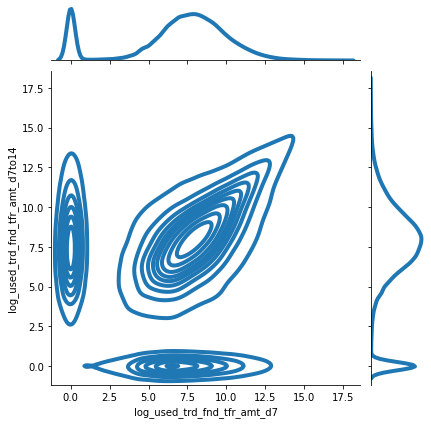

In [33]:
sns.jointplot(x = x.name, y = y.name, kind = "kde", data = X)
plt.show()

To add more layers onto the plot, use the methods on the [seaborn.JointGrid](https://seaborn.pydata.org/generated/seaborn.JointGrid.html).

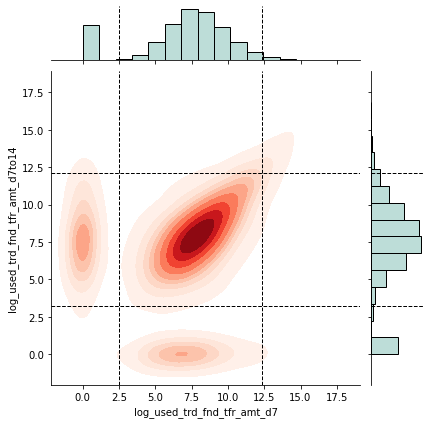

In [48]:
g = sns.JointGrid(data=X.sample(10000), x=x.name, y=y.name)
g.plot_joint(sns.kdeplot, shade=True, cmap="Reds", n_levels=10)
# g.plot_joint(sns.scatterplot, s=20, alpha=0.2)
g.plot_marginals(sns.histplot, kde=False, bins=15, color="#A7D2CB")
g.refline(x=xyref[0][0], y=xyref[1][0], lw=1, color="k")
g.refline(x=xyref[0][1], y=xyref[1][1], lw=1, color="k")
plt.show()

Use matplotlib

In [51]:
def JointPlot(X, x:str, y:str, s=20, kde=None):
    '''
    Draw a plot of two variables with bivariate and univariate graphs.
    
    Parameters
    ----------
    X : pd.DataFrame
        Input data.

    x, y : str
        Variables that specify positions on the x and y axes.
        
    s : float or array-like, shape (n, ), default=20
        The marker size in points.

    kde : array-like, default=None
        A scalar or sequence of n numbers to be mapped to colors 
        using cmap
    
    Returns
    -------
    a list of bivariate, and univariate of x and y, respectively.
        
    '''
    fig = plt.figure(figsize=(6.5,6))
    gs = GridSpec(5,5)
    x1 = X[x].values.copy()
    x2 = X[y].values.copy()
    ax = fig.add_subplot(gs[1:5,0:4])
    hx = fig.add_subplot(gs[0,0:4], sharex=ax)
    hy = fig.add_subplot(gs[1:5,4], sharey=ax)
    
    kwds = dict(marker='o', alpha=0.4, s=s)
    if kde is not None: 
        kwds.update(dict(c=kde, cmap=cm.get_cmap("Reds",20)))
    ax.scatter(x1, x2, **kwds)
    
    kwds = dict(density=True, bins=15, ec="k", color="#A7D2CB")
    hx.hist(x1, **kwds)
    hy.hist(x2, **{**kwds,**dict(orientation='horizontal')})

    hy.get_xaxis().set_visible(False)
    hy.spines["bottom"].set_visible(False)
    plt.setp(hy.get_yticklabels(), visible=False)

    hx.get_yaxis().set_visible(False)
    plt.setp(hx.get_xticklabels(), visible=False)
    hx.spines["left"].set_visible(False)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel(x, fontsize=12)
    ax.set_ylabel(y, fontsize=12)
    plt.tight_layout()
    
    return [ax, hx, hy]

In [60]:
def plot_ref(axes, values=None, is_x=True):
    kwds = dict(lw=1, ls="--", c="k")
    for ax in axes:
        for v in values:
            if is_x: ax.axvline(v, **kwds)
            else: ax.axhline(v, **kwds)

In [133]:
def milify_number(k, decimal=2):
    suffixes = ['','K','M','B','T','Q']
    decimal = decimal if k>0 else 0
    str_format = ('{:,.' + str(decimal) + 'f}{}').format
    exp = int(np.floor((np.log(k)/np.log(10))/3)) if k>0 else 0
    return str_format(k/10**(exp*3),suffixes[exp])

In [145]:
def change_ticklabels(ax, x_axis=True, rotation=45, decimal=2):
    axis = "x" if x_axis else "y"
    lim = getattr(ax, f"get_{axis}lim")()
    ticks = getattr(ax, f"get_{axis}ticks")()
    labels = [milify_number(np.exp(float(t))-1, decimal) for t in ticks]
    getattr(ax, f"set_{axis}ticks")(ticks)
    getattr(ax, f"set_{axis}ticklabels")(labels, rotation=rotation)
    getattr(ax, f"set_{axis}lim")(*lim)
    return ax

Create KDE layer

In [49]:
data = np.vstack((x, y))
kde  = gaussian_kde(data).evaluate(data)

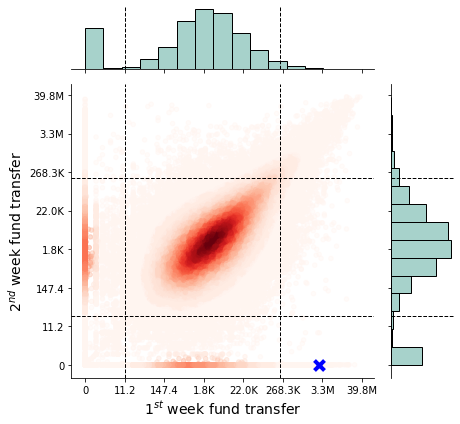

In [152]:
axes = JointPlot(X, x=x.name, y=y.name, kde=kde)
plot_ref(np.array(axes)[[0,1]], xyref[0].tolist())
plot_ref(np.array(axes)[[0,2]], xyref[1].tolist(), False)
args = X.loc[X["target"]==1,[x.name, y.name]].values.ravel()
axes[0].scatter(*args, s=100, c="b", marker="x")
change_ticklabels(axes[0], True, 0, 1)
change_ticklabels(axes[0], False, 0, 1)
axes[0].set_xlabel(r"$1^{st}$ week fund transfer", fontsize=14)
axes[0].set_ylabel(r"$2^{nd}$ week fund transfer", fontsize=14)
plt.tight_layout()
plt.show()